In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  


In [3]:
%pwd


'/Users/mayanknautiyal/Desktop/Codes/CVAEI/notebooks'

In [4]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.examples.villar import Villar
from cvaei.models.conv_cvae import CNN_CVAE
import multiprocessing as mp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [5]:
villar = Villar()
#mp.set_start_method('spawn')
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = villar.prepare_data(10, scale = False)
#observed_data = villar.observed_data()
#villar.check_normalizer()

Generating data...
Training Theta Shape: torch.Size([10, 15])
Training Data Shape: torch.Size([10, 3, 200])
Generating data...
Validation Theta Shape: torch.Size([4, 15])
Validation Data Shape: torch.Size([4, 3, 200])


In [6]:
train_data_norm[3]

tensor([[1.0000e+01, 9.9000e+01, 3.1300e+02, 6.6400e+02, 1.0770e+03, 1.4770e+03,
         1.2850e+03, 6.1600e+02, 3.5800e+02, 3.2400e+02, 2.8600e+02, 2.7300e+02,
         2.7200e+02, 2.5300e+02, 2.6200e+02, 2.2800e+02, 2.8900e+02, 2.5200e+02,
         3.1600e+02, 3.3100e+02, 3.3700e+02, 3.3200e+02, 2.3000e+02, 2.9800e+02,
         3.0100e+02, 2.7700e+02, 2.6800e+02, 2.5100e+02, 4.0700e+02, 5.8200e+02,
         8.2500e+02, 1.1430e+03, 1.5180e+03, 1.4430e+03, 6.6000e+02, 4.2100e+02,
         2.8500e+02, 2.3400e+02, 2.2300e+02, 2.3200e+02, 2.1600e+02, 2.4600e+02,
         2.9700e+02, 2.6500e+02, 2.2000e+02, 2.0800e+02, 2.3400e+02, 1.9500e+02,
         2.6300e+02, 1.9700e+02, 3.8400e+02, 4.8100e+02, 6.7100e+02, 9.9600e+02,
         1.3440e+03, 1.6650e+03, 7.9200e+02, 4.3500e+02, 3.1800e+02, 2.7900e+02,
         2.3200e+02, 1.9000e+02, 2.6200e+02, 3.1500e+02, 2.6600e+02, 2.3400e+02,
         3.2600e+02, 2.7600e+02, 2.6400e+02, 2.5600e+02, 1.9900e+02, 2.3000e+02,
         2.6200e+02, 2.7500e

In [7]:
#villar.plot_observation(observed_data)

# Initialise the Model

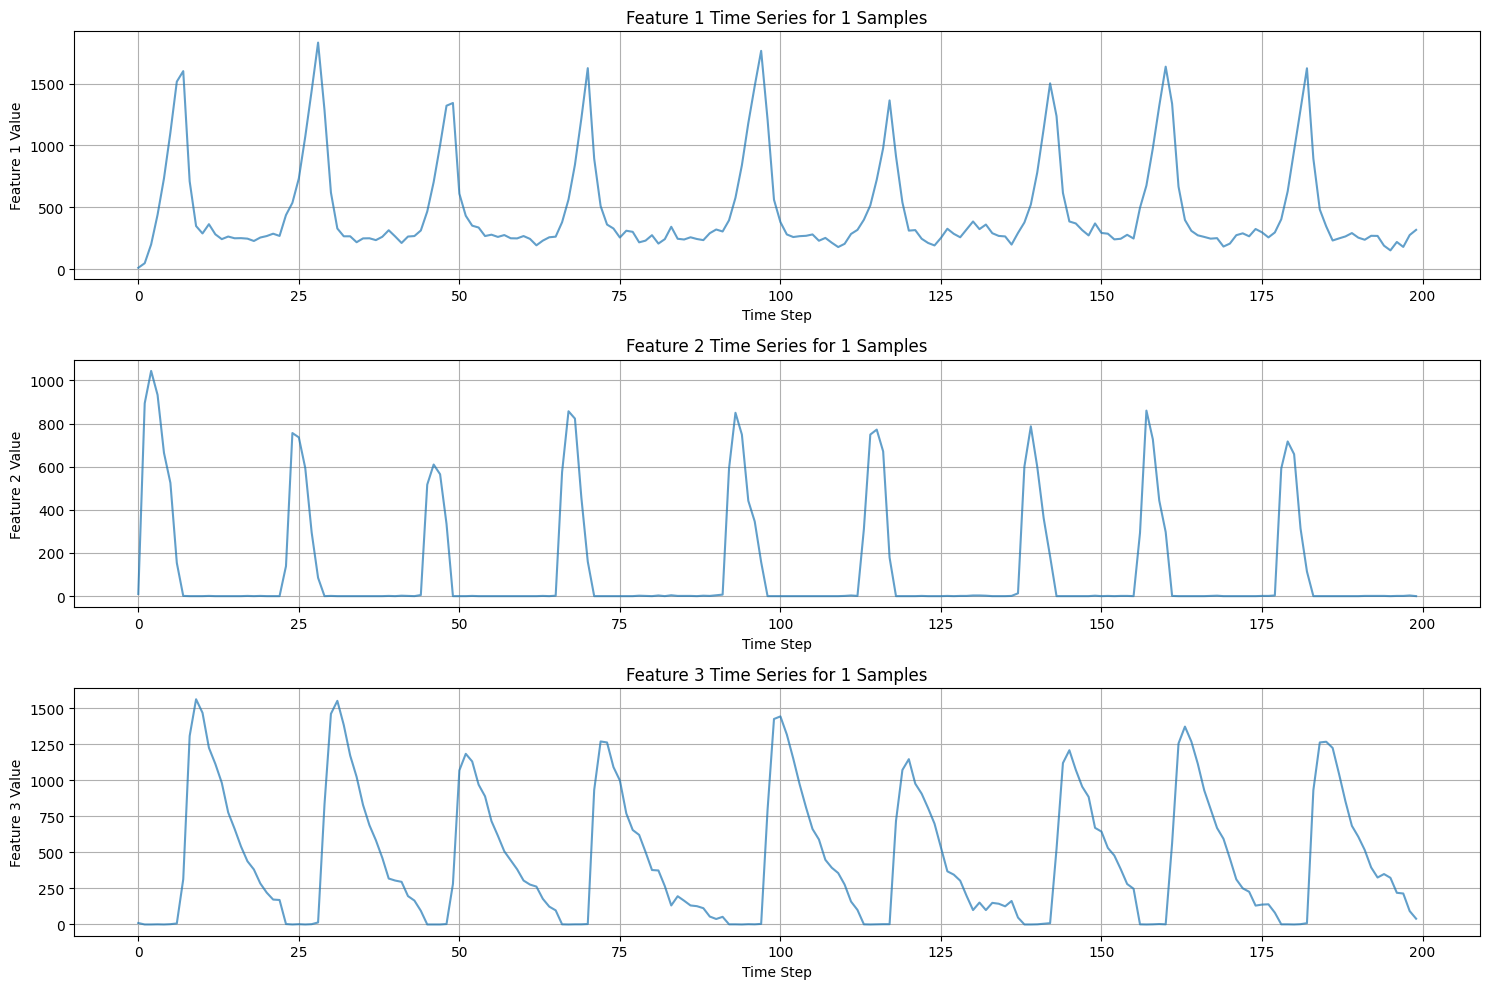

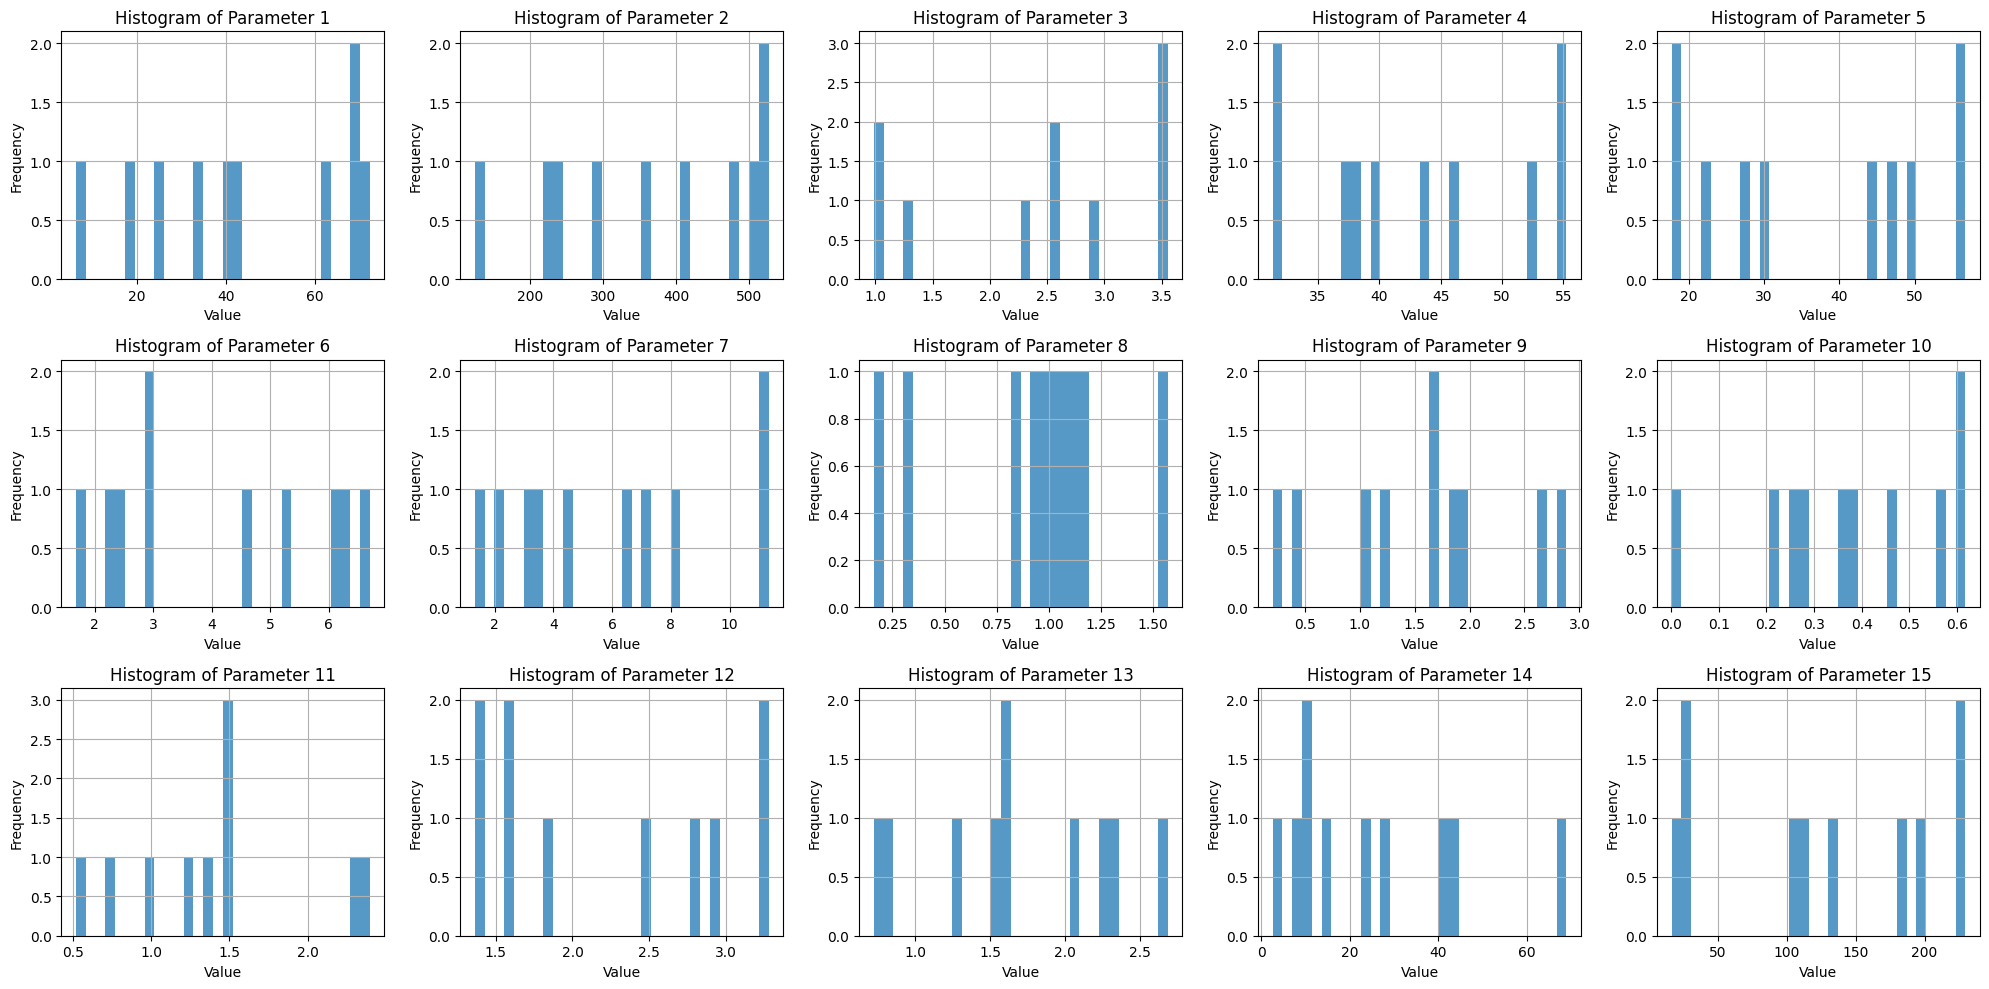

In [8]:
villar.plot_observation(train_data_norm, num_samples =1)
villar.plot_prior(train_theta_norm)

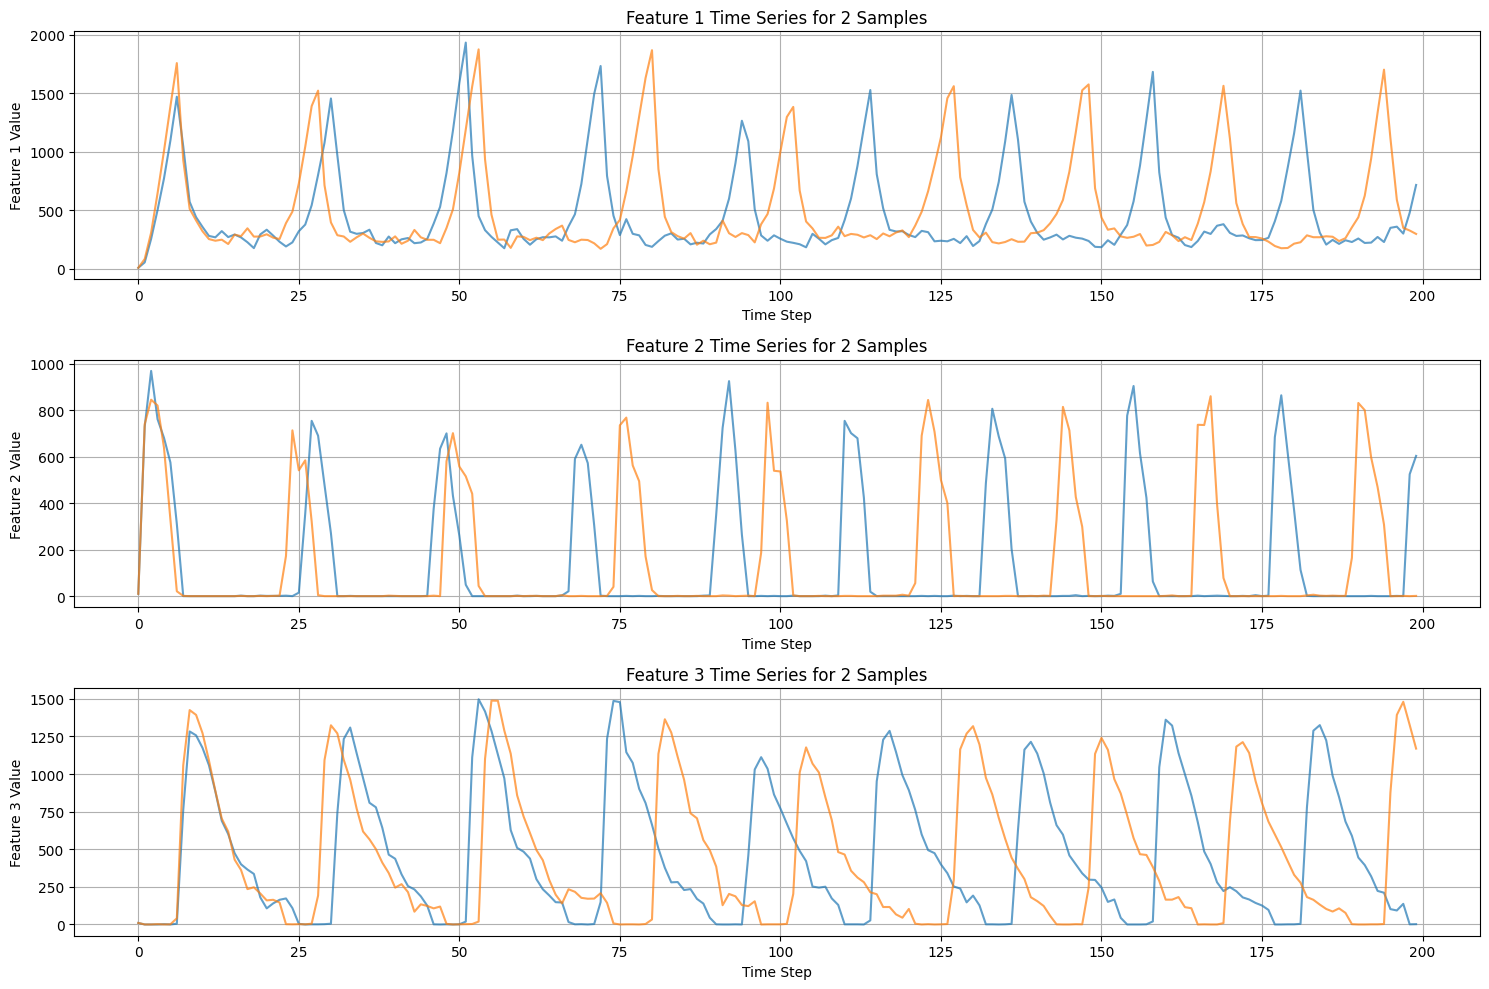

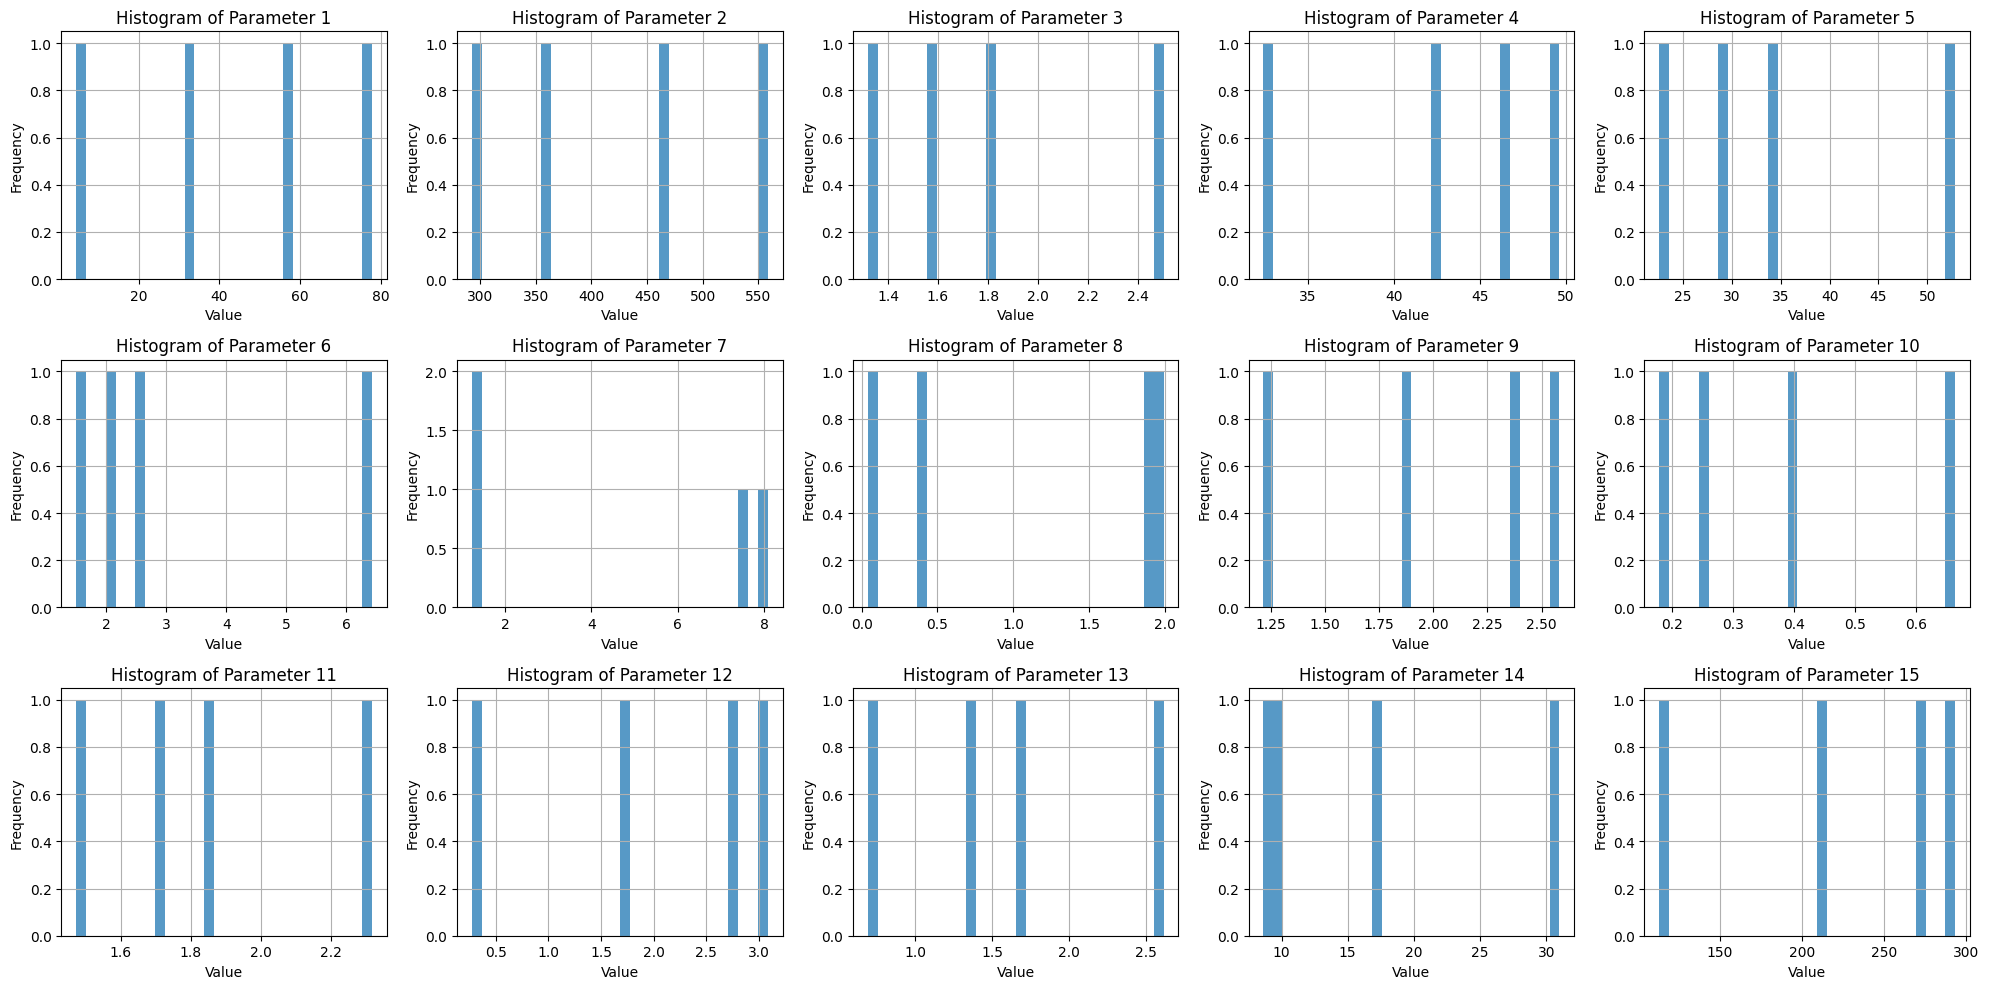

In [9]:
villar.plot_observation(val_data_norm, num_samples =2)
villar.plot_prior(val_theta_norm)

# Define the CVAE Network

In [10]:
# Instantiate the CNN_CVAE model
input_dim = 15  # Example input dimension
latent_dim = 200  # Example latent space dimension
conditional_dim = (3,200)  # Based on Nx3x200 conditional input
encoder_hidden_dims = [200]  # Example hidden dimensions for the encoder
sequence_length = 200  # Length of sequences in the conditional input
conv_output_channels = [64, 32,16]  # Channels in each Conv1D layer for the decoder
kernel_sizes = [3, 3, 3 ]  # Kernel sizes for the Conv1D layers in the decoder
output_channels = 3  # Matching the original conditional input's channels



network = CNN_CVAE(
    input_dim=input_dim,
    latent_dim=latent_dim,
    conditional_dim=conditional_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    conv_output_channels = conv_output_channels,
    kernel_sizes=kernel_sizes,
    activation_fn= nn.LeakyReLU(0.1),
    w_recon=0.1,
    w_misfit=1.0,
    kld=1.0
)

optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

print(network)

CNN_CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=15, out_features=200, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=200, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=200, out_features=200, bias=True)
  )
  (decoder): CNN_Decoder(
    (activation_fn): LeakyReLU(negative_slope=0.1)
    (fc_expand): Linear(in_features=200, out_features=200, bias=True)
    (convolutional_sequence): Sequential(
      (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): BatchNorm1d(16

In [11]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    
                    patience=100)

Using CPU for training.
Epoch 1/20: Beta: 0.0, total_loss: 0.2402, recon_loss: 65.6885, misfit_loss: 210948.3000, kl_div: 0.0000
Epoch 1/20 Validation: total_loss: nan, recon_loss: 88.0482, misfit_loss: 212305.4688, kl_div: nan

Epoch 1: No improvement in validation loss for 1 epochs.
Epoch 2/20: Beta: 0.1, total_loss: inf, recon_loss: 65.5124, misfit_loss: 210940.9750, kl_div: inf
Epoch 2/20 Validation: total_loss: nan, recon_loss: nan, misfit_loss: nan, kl_div: nan

Epoch 2: No improvement in validation loss for 2 epochs.
Epoch 3/20: Beta: 0.2, total_loss: nan, recon_loss: nan, misfit_loss: nan, kl_div: nan
Epoch 3/20 Validation: total_loss: nan, recon_loss: nan, misfit_loss: nan, kl_div: nan

Epoch 3: No improvement in validation loss for 3 epochs.
Epoch 4/20: Beta: 0.3, total_loss: nan, recon_loss: nan, misfit_loss: nan, kl_div: nan
Epoch 4/20 Validation: total_loss: nan, recon_loss: nan, misfit_loss: nan, kl_div: nan

Epoch 4: No improvement in validation loss for 4 epochs.
Epoch 

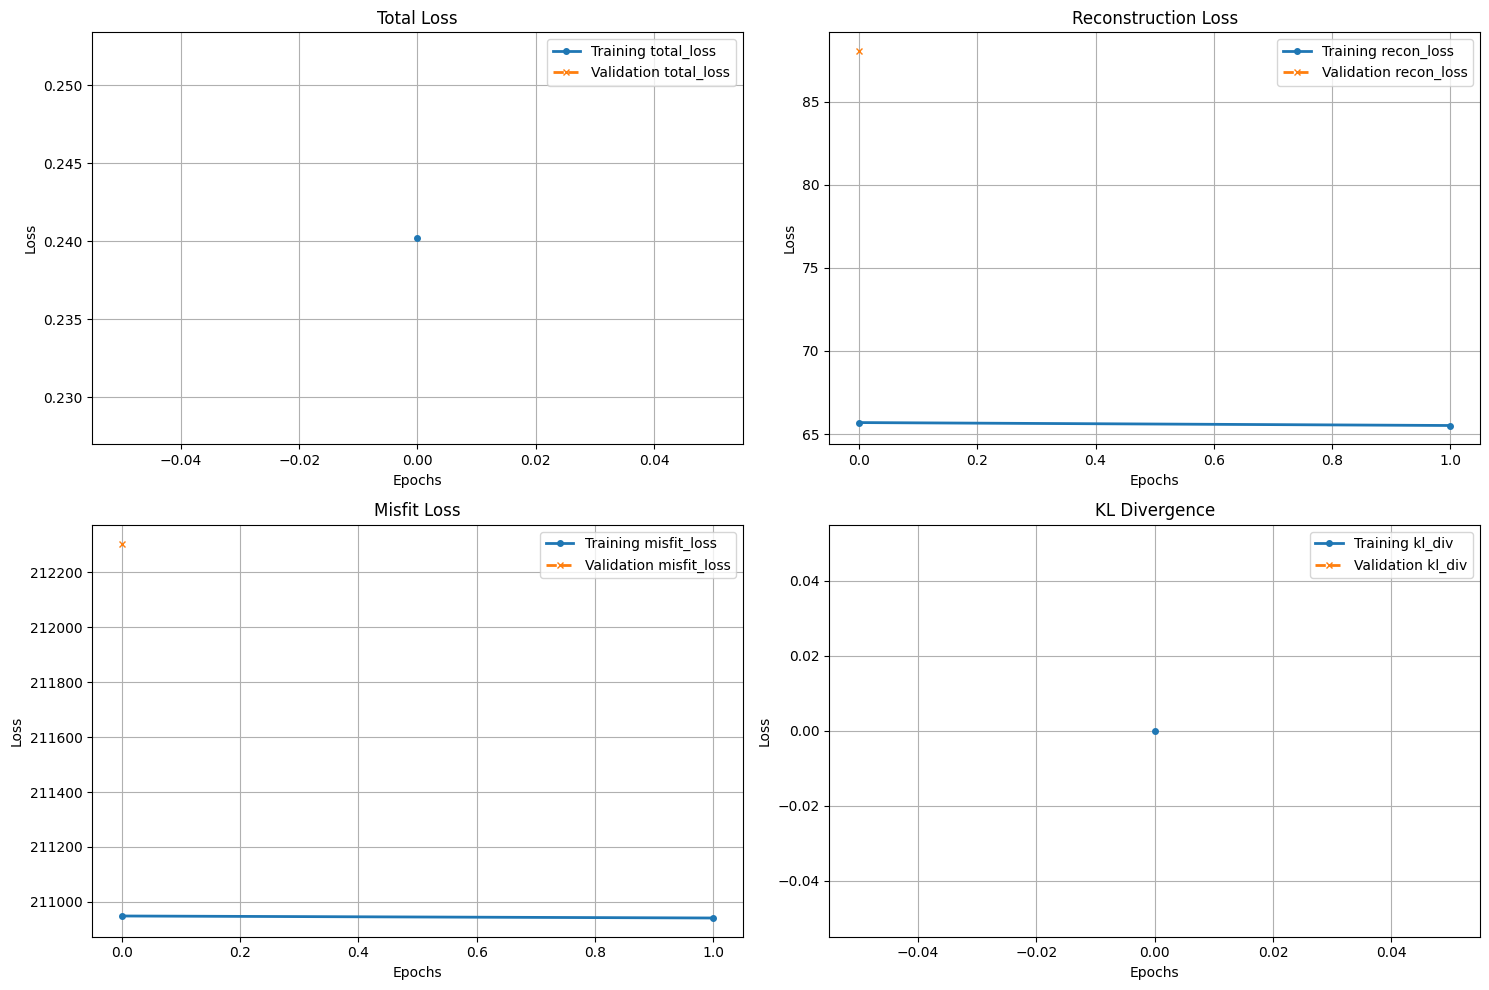

In [12]:
network.plot_loss()

# Inference

In [13]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)
villar.posterior_hist(post)

NameError: name 'observed_data' is not defined

In [ ]:
import os
#import dask
#os.environ['PATH'] += ":/usr/local/cuda/bin/"
import numpy as np
import pandas as pd
import gillespy2
from gillespy2 import SSACSolver
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event
from gillespy2.core.events import *
import sciope
import multiprocessing as mp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Vilar_Oscillator(gillespy2.Model):
    def __init__(self, parameter_values=None):
        gillespy2.Model.__init__(self, name="Vilar_Oscillator")
        self.volume = 1

        # Parameters
        self.add_parameter(gillespy2.Parameter(name="alpha_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="alpha_a_prime", expression=500))
        self.add_parameter(gillespy2.Parameter(name="alpha_r", expression=0.01))
        self.add_parameter(gillespy2.Parameter(name="alpha_r_prime", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_r", expression=5))
        self.add_parameter(gillespy2.Parameter(name="delta_ma", expression=10))
        self.add_parameter(gillespy2.Parameter(name="delta_mr", expression=0.5))
        self.add_parameter(gillespy2.Parameter(name="delta_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="delta_r", expression=0.2))
        self.add_parameter(gillespy2.Parameter(name="gamma_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_r", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_c", expression=2))
        self.add_parameter(gillespy2.Parameter(name="theta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="theta_r", expression=100))

        # Species
        self.add_species(gillespy2.Species(name="Da", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Ma", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Mr", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="C", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="A", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="R", initial_value=10, mode="discrete"))

        # Reactions
        self.add_reaction(gillespy2.Reaction(name="r1", reactants={'Da_prime': 1}, products={'Da': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r2", reactants={'Da': 1, 'A': 1}, products={'Da_prime': 1}, rate=self.listOfParameters["gamma_a"]))
        self.add_reaction(gillespy2.Reaction(name="r3", reactants={'Dr_prime': 1}, products={'Dr': 1}, rate=self.listOfParameters["theta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r4", reactants={'Dr': 1, 'A': 1}, products={'Dr_prime': 1}, rate=self.listOfParameters["gamma_r"]))
        self.add_reaction(gillespy2.Reaction(name="r5", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r6", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a"]))
        self.add_reaction(gillespy2.Reaction(name="r7", reactants={'Ma': 1}, products={}, rate=self.listOfParameters["delta_ma"]))
        self.add_reaction(gillespy2.Reaction(name="r8", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate=self.listOfParameters["beta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r9", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r10", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r11", reactants={'A': 1}, products={}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r12", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r13", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r14", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r"]))
        self.add_reaction(gillespy2.Reaction(name="r15", reactants={'Mr': 1}, products={}, rate=self.listOfParameters["delta_mr"]))
        self.add_reaction(gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate=self.listOfParameters["beta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r17", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r18", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_a"]))

        # Timespan
        self.timespan(np.linspace(0, 200, 200))
        
model = Vilar_Oscillator()
solver = SSACSolver(model=model)
parameter_names = ['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime', 
                   'beta_a', 'beta_r', 'delta_ma', 'delta_mr', 'delta_a', 
                   'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r']

# def simulator(params, model = model, transform = True):
    
#     params = params.ravel()
#     res = model.run(
#             solver = solver,
#             timeout = 0.33,
#             variables = {parameter_names[i] : params[i] for i in range(len(parameter_names))})
    
#     if res.rc == 33:
#         return np.ones((1,3,200))
#     if transform:
#         sp_C = res['C']
#         sp_A = res['A']
#         sp_R = res['R']
#         return np.vstack([sp_C, sp_A, sp_R])[np.newaxis,:,:]
 
#     else:
#         return res
    
def simulator(params, model = model):
        
        params_dict = {parameter_names[i]: param for i, param in enumerate(params)}
        result = model.run(solver=solver, timeout=0.7, variables=params_dict)
        
        if result.rc == 33:  # Timeout or error
            return np.full((3, 200), np.inf)
        else:
            return np.array([result[species] for species in ['C', 'A', 'R']])
    
dmin = [0,    100,    0,   20,   10,   1,    1,   0,   0,   0, 0.5,    0,   0,    0,   0]
dmax = [80,   600,    4,   60,   60,   7,   12,   2,   3, 0.7, 2.5,   4,   3,   70,   300]
true_param = np.asarray([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0]).reshape(1,-1) 

def generate_data_parallel(N):
    """ Returns the parameters and TS data using parallel processing"""
    params = np.random.uniform(low=dmin, high=dmax, size=(N,15))
    with mp.Pool(processes=96) as pool:
        ts = pool.map(simulator, params)
    ts = np.asarray(ts)
    return ts,params

train_ts, train_params = generate_data_parallel(10000)

In [ ]:
def count_ones_samples(train_ts):
    target = np.full((3, 200), np.inf)
    count = 0
    
    for sample in train_ts:
        # Check if any element in the sample is inf (np.inf)
        if np.isinf(sample).any():
            count += 1
            
    return count
count_ones_samples(train_ts)

In [ ]:
train_ts[19]

In [ ]:
train_ts.shape